In [2]:
import os,cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Flatten
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils import np_utils
from keras.models import Sequential
from tensorflow.python.keras.layers.core import Dense, Dropout, Activation, Flatten
from tensorflow.python.keras.layers.convolutional import Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os
from keras.layers import Activation, Conv2D, Dropout
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D,AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling1D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install split-folders

In [3]:
img_rows=224
num_classes=6
img_cols=224
num_channel=3

In [ ]:

import splitfolders
# splitfolders.ratio('/content/drive/MyDrive/Preprocessing_frames/UCF-ARG Data Set/3 FPS', output="output128", seed=1337, ratio=(0.6,0.2,0.2))
splitfolders.ratio('/content/drive/MyDrive/China_revised_HAR_Data', output="output23", seed=1337, ratio=(0.7,0.15,0.15))

Copying files: 5078 files [13:44,  1.58 files/s]

KeyboardInterrupt: 

In [ ]:

TRAINING_DIR = "/content/output23/train"
#TRAINING_DIR = "/content/output23/train"

# train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True

train_datagen = ImageDataGenerator(rescale = 1/255.0)

train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=16,
                                                    class_mode='categorical',
                                                    target_size=(img_rows, img_cols),shuffle=True)

In [ ]:
VALIDATION_DIR = '/content/output23/val' ## interpolated
#VALIDATION_DIR = '/content/output23/val'

validation_datagen = ImageDataGenerator(rescale = 1/255.0)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=16,
                                                              class_mode='categorical',
                                                              target_size=(img_rows, img_cols)
                                                             )

## ECA module Based CNN Model

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, LeakyReLU,PReLU,ELU

input_shape=(224,224,3)
##mini_exceptin

img_input = Input(input_shape)
x = SeparableConv2D(16, (3, 3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal", use_bias=False)(img_input)
x = BatchNormalization()(x)
x_offset =  LeakyReLU(alpha=0.2)(x)
# x = keras.layers.Conv2D(64, (3, 3),dilation_rate=(3,3),padding='same',use_bias=False)(x_offset)
# x = BatchNormalization()(x)
# x_offset = Activation('relu')(x)

x_offset


/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


<KerasTensor shape=(None, 224, 224, 16), dtype=float32, sparse=False, name=keras_tensor_3>

## Block 1

In [5]:
# module 1
from tensorflow.keras.layers import Concatenate, Add,SeparableConv2D, BatchNormalization, ReLU, Activation

# Input to dense block
x = x_offset  # This is the input to the dense block

# First SeparableConv2D layer
layer1 = SeparableConv2D(16, (3,3), strides=(1, 1), padding='same',
                         depthwise_initializer='he_normal', pointwise_initializer='he_normal',
                         use_bias=False)(x)
layer1 = BatchNormalization()(layer1)
layer1 = LeakyReLU(alpha=0.2)(layer1)

# Concatenate input with the output of the first layer
# concat1 = Add()([x, layer1])

# Second SeparableConv2D layer
layer2 = SeparableConv2D(16, (3,3), strides=(1, 1), padding='same',
                         depthwise_initializer='he_normal', pointwise_initializer='he_normal',
                         use_bias=False)(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = LeakyReLU(alpha=0.2)(layer2)

# Concatenate input, first layer output, and second layer output
concat2 = Add()([layer1, layer2])

# Third SeparableConv2D layer
layer3 = SeparableConv2D(16, (3,3), strides=(1, 1), padding='same',
                         depthwise_initializer='he_normal', pointwise_initializer='he_normal',
                         use_bias=False)(concat2)
layer3 = BatchNormalization()(layer3)
layer3 = LeakyReLU(alpha=0.2)(layer3)

# Final concatenation of all layers' outputs
output = Add()([concat2, layer3])





output.shape

(None, 224, 224, 16)

ECA Attention Module

In [6]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling2D, Reshape, Multiply

In [7]:
class ECALayer(tf.keras.layers.Layer):
    def __init__(self, k_size=3, **kwargs):
        super(ECALayer, self).__init__(**kwargs)  # Pass any extra arguments to the parent class
        self.k_size = k_size
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)
        self.conv1d = tf.keras.layers.Conv1D(filters=1, kernel_size=k_size, padding='same', use_bias=False)
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def call(self, inputs):
        y = self.avg_pool(inputs)  # Shape: (batch_size, 1, 1, channels)
        y = tf.squeeze(y, axis=[1, 2])  # Shape: (batch_size, channels)
        y = self.conv1d(tf.expand_dims(y, axis=-1))  # Shape: (batch_size, channels, 1)
        y = tf.squeeze(y, axis=-1)  # Shape: (batch_size, channels)
        y = self.sigmoid(y)  # Shape: (batch_size, channels)
        y = tf.reshape(y, (-1, 1, 1, y.shape[-1]))  # Shape: (batch_size, 1, 1, channels)
        return inputs * y

In [8]:
# Create an instance of the ECALayer
eca_layer = ECALayer(k_size=3)

# Apply ECA module to the input
channel_attention_map1 = eca_layer(x_offset)
channel_attention_map1.shape

(None, 224, 224, 16)

In [9]:
x111 = layers.add([channel_attention_map1,output])
x111.shape

(None, 224, 224, 16)

## Dilation Convolution Layer

In [10]:

x =  SeparableConv2D(32, (3,3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation= ELU(), use_bias=False)(x111)
x = BatchNormalization()(x)
x_offset =  LeakyReLU(alpha=0.2)(x)
x_offset = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x_offset)
# x = keras.layers.Conv2D(64, (3, 3),dilation_rate=(3,3),padding='same',use_bias=False)(x)
# x = BatchNormalization()(x)
# x_offset = Activation('relu')(x)
x_offset

<KerasTensor shape=(None, 112, 112, 32), dtype=float32, sparse=False, name=keras_tensor_21>

## Block 2

In [11]:

# module 1
from tensorflow.keras.layers import Concatenate, Add,SeparableConv2D, BatchNormalization, ReLU, Activation

# Input to dense block
x = x_offset  # This is the input to the dense block

# First SeparableConv2D layer
layer1 = SeparableConv2D(32, (3,3), strides=(1, 1), padding='same',
                         depthwise_initializer='he_normal', pointwise_initializer='he_normal',
                         use_bias=False)(x)
layer1 = BatchNormalization()(layer1)
layer1 =  LeakyReLU(alpha=0.2)(layer1)

# Concatenate input with the output of the first layer
# concat1 = Add()([x, layer1])

# Second SeparableConv2D layer
layer2 = SeparableConv2D(32, (3,3), strides=(1, 1), padding='same',
                         depthwise_initializer='he_normal', pointwise_initializer='he_normal',
                         use_bias=False)(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = LeakyReLU(alpha=0.2)(layer2)

# Concatenate input, first layer output, and second layer output
concat2 = Add()([layer1, layer2])

# Third SeparableConv2D layer
layer3 = SeparableConv2D(32, (3,3), strides=(1, 1), padding='same',
                         depthwise_initializer='he_normal', pointwise_initializer='he_normal',
                         use_bias=False)(concat2)
layer3 = BatchNormalization()(layer3)
layer3 =  LeakyReLU(alpha=0.2)(layer3)

# Final concatenation of all layers' outputs
output = Add()([concat2, layer3])





output.shape

(None, 112, 112, 32)

ECA Attention Module

In [12]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling2D, Reshape, Multiply

In [13]:
# import tensorflow as tf
# from tensorflow.keras.layers import GlobalAveragePooling2D, Conv1D, Lambda

# # ECA Module (Efficient Channel Attention)
# def eca_module(x, k_size=3):
#     # Global Average Pooling
#     squeeze = GlobalAveragePooling2D()(x)

#     # Expand dimensions to match Conv1D input requirements
#     squeeze = Lambda(lambda x: tf.expand_dims(x, axis=1))(squeeze)

#     # 1D Convolution
#     attn = Conv1D(filters=1,
#                   kernel_size=k_size,
#                   padding='same',
#                   kernel_initializer='he_normal',
#                   use_bias=False)(squeeze)

#     # Apply sigmoid activation
#     attn = Lambda(lambda x: tf.expand_dims(tf.transpose(x, [0, 2, 1]), axis=3))(attn)
#     attn = Lambda(lambda x: tf.math.sigmoid(x))(attn)

#     # Scale the input by the attention weights
#     scale = Lambda(lambda x: x[0] * x[1])([x, attn])

#     return scale



In [14]:
import tensorflow as tf
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv1D, Lambda

import tensorflow as tf
from tensorflow.keras import layers

class ECALayer(tf.keras.layers.Layer):
    def __init__(self, k_size=3, **kwargs):
        super(ECALayer, self).__init__(**kwargs)  # Pass any extra arguments to the parent class
        self.k_size = k_size
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)
        self.conv1d = tf.keras.layers.Conv1D(filters=1, kernel_size=k_size, padding='same', use_bias=False)
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def call(self, inputs):
        y = self.avg_pool(inputs)  # Shape: (batch_size, 1, 1, channels)
        y = tf.squeeze(y, axis=[1, 2])  # Shape: (batch_size, channels)
        y = self.conv1d(tf.expand_dims(y, axis=-1))  # Shape: (batch_size, channels, 1)
        y = tf.squeeze(y, axis=-1)  # Shape: (batch_size, channels)
        y = self.sigmoid(y)  # Shape: (batch_size, channels)
        y = tf.reshape(y, (-1, 1, 1, y.shape[-1]))  # Shape: (batch_size, 1, 1, channels)
        return inputs * y





In [15]:
# Create an instance of the ECALayer
eca_layer = ECALayer(k_size=3)

# Apply ECA module to the input
channel_attention_map1 = eca_layer(x_offset)
channel_attention_map1.shape

(None, 112, 112, 32)

In [16]:
x112 = layers.add([channel_attention_map1,output])
x112.shape

(None, 112, 112, 32)

## Dilation Convolution Layer

In [17]:

x =  SeparableConv2D(64, (3,3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation=LeakyReLU(alpha=0.2), use_bias=False)(x112)
x = BatchNormalization()(x)
x_offset =  LeakyReLU(alpha=0.2)(x)
x_offset = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x_offset)
# x = keras.layers.Conv2D(64, (3, 3),dilation_rate=(3,3),padding='same',use_bias=False)(x)
# x = BatchNormalization()(x)
# x_offset = Activation('relu')(x)
x_offset

<KerasTensor shape=(None, 56, 56, 64), dtype=float32, sparse=False, name=keras_tensor_39>

##Block 3

In [18]:
# module 1
from tensorflow.keras.layers import Concatenate, Add,SeparableConv2D, BatchNormalization, ReLU, Activation

# Input to dense block
x = x_offset  # This is the input to the dense block

# First SeparableConv2D layer
layer1 = SeparableConv2D(64, (3,3), strides=(1, 1), padding='same',
                         depthwise_initializer='he_normal', pointwise_initializer='he_normal',
                         use_bias=False)(x)
layer1 = BatchNormalization()(layer1)
layer1 =  LeakyReLU(alpha=0.2)(layer1)

# Concatenate input with the output of the first layer
# concat1 = Add()([x, layer1])

# Second SeparableConv2D layer
layer2 = SeparableConv2D(64, (3,3), strides=(1, 1), padding='same',
                         depthwise_initializer='he_normal', pointwise_initializer='he_normal',
                         use_bias=False)(layer1)
layer2 = BatchNormalization()(layer2)
layer2 =   LeakyReLU(alpha=0.2)(layer2)

# Concatenate input, first layer output, and second layer output
concat2 = Add()([layer1, layer2])

# Third SeparableConv2D layer
layer3 = SeparableConv2D(64, (3,3), strides=(1, 1), padding='same',
                         depthwise_initializer='he_normal', pointwise_initializer='he_normal',
                         use_bias=False)(concat2)
layer3 = BatchNormalization()(layer3)
layer3 =   LeakyReLU(alpha=0.2)(layer3)

# Final concatenation of all layers' outputs
output = Add()([concat2, layer3])





output.shape

(None, 56, 56, 64)

ECA Attention Module

In [19]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling2D, Reshape, Multiply

In [20]:
# import tensorflow as tf
# from tensorflow.keras.layers import GlobalAveragePooling2D, Conv1D, Lambda

# # ECA Module (Efficient Channel Attention)
# def eca_module(x, k_size=3):
#     # Global Average Pooling
#     squeeze = GlobalAveragePooling2D()(x)

#     # Expand dimensions to match Conv1D input requirements
#     squeeze = Lambda(lambda x: tf.expand_dims(x, axis=1))(squeeze)

#     # 1D Convolution
#     attn = Conv1D(filters=1,
#                   kernel_size=k_size,
#                   padding='same',
#                   kernel_initializer='he_normal',
#                   use_bias=False)(squeeze)

#     # Apply sigmoid activation
#     attn = Lambda(lambda x: tf.expand_dims(tf.transpose(x, [0, 2, 1]), axis=3))(attn)
#     attn = Lambda(lambda x: tf.math.sigmoid(x))(attn)

#     # Scale the input by the attention weights
#     scale = Lambda(lambda x: x[0] * x[1])([x, attn])

#     return scale



In [21]:
class ECALayer(tf.keras.layers.Layer):
    def __init__(self, k_size=3, **kwargs):
        super(ECALayer, self).__init__(**kwargs)  # Pass any extra arguments to the parent class
        self.k_size = k_size
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)
        self.conv1d = tf.keras.layers.Conv1D(filters=1, kernel_size=k_size, padding='same', use_bias=False)
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def call(self, inputs):
        y = self.avg_pool(inputs)  # Shape: (batch_size, 1, 1, channels)
        y = tf.squeeze(y, axis=[1, 2])  # Shape: (batch_size, channels)
        y = self.conv1d(tf.expand_dims(y, axis=-1))  # Shape: (batch_size, channels, 1)
        y = tf.squeeze(y, axis=-1)  # Shape: (batch_size, channels)
        y = self.sigmoid(y)  # Shape: (batch_size, channels)
        y = tf.reshape(y, (-1, 1, 1, y.shape[-1]))  # Shape: (batch_size, 1, 1, channels)
        return inputs * y

In [22]:
# Create an instance of the ECALayer
eca_layer = ECALayer(k_size=3)

# Apply ECA module to the input
channel_attention_map1 = eca_layer(x_offset)
channel_attention_map1.shape

(None, 56, 56, 64)

In [23]:
x113 = layers.add([channel_attention_map1,output])
x113.shape

(None, 56, 56, 64)

## Dilation Convolution Layer

In [24]:

x =  SeparableConv2D(128, (3,3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation=LeakyReLU(alpha=0.2), use_bias=False)(x113)
x = BatchNormalization()(x)
x_offset =  LeakyReLU(alpha=0.2)(x)
x_offset = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x_offset)
# x = keras.layers.Conv2D(64, (3, 3),dilation_rate=(3,3),padding='same',use_bias=False)(x)
# x = BatchNormalization()(x)
# x_offset = Activation('relu')(x)
x_offset

<KerasTensor shape=(None, 28, 28, 128), dtype=float32, sparse=False, name=keras_tensor_57>

## Block4

In [25]:
# module 1
from tensorflow.keras.layers import Concatenate, Add,SeparableConv2D, BatchNormalization, ReLU, Activation

# Input to dense block
x = x_offset  # This is the input to the dense block

# First SeparableConv2D layer
layer1 = SeparableConv2D(128, (3,3), strides=(1, 1), padding='same',
                         depthwise_initializer='he_normal', pointwise_initializer='he_normal',
                         use_bias=False)(x)
layer1 = BatchNormalization()(layer1)
layer1 =   LeakyReLU(alpha=0.2)(layer1)

# Concatenate input with the output of the first layer
# concat1 = Add()([x, layer1])

# Second SeparableConv2D layer
layer2 = SeparableConv2D(128, (3,3), strides=(1, 1), padding='same',
                         depthwise_initializer='he_normal', pointwise_initializer='he_normal',
                         use_bias=False)(layer1)
layer2 = BatchNormalization()(layer2)
layer2 =  LeakyReLU(alpha=0.2)(layer2)

# Concatenate input, first layer output, and second layer output
concat2 = Add()([layer1, layer2])

# Third SeparableConv2D layer
layer3 = SeparableConv2D(128, (3,3), strides=(1, 1), padding='same',
                         depthwise_initializer='he_normal', pointwise_initializer='he_normal',
                         use_bias=False)(concat2)
layer3 = BatchNormalization()(layer3)
layer3 =   LeakyReLU(alpha=0.2)(layer3)

# Final concatenation of all layers' outputs
output = Add()([concat2, layer3])





output.shape

(None, 28, 28, 128)

ECA Attention Module

In [26]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling2D, Reshape, Multiply

In [27]:
# import tensorflow as tf
# from tensorflow.keras.layers import GlobalAveragePooling2D, Conv1D, Lambda

# # ECA Module (Efficient Channel Attention) with explicit output_shape
# def eca_module(x, k_size=3):
#     # Global Average Pooling
#     squeeze = GlobalAveragePooling2D()(x)

#     # Expand dimensions to match Conv1D input requirements
#     squeeze = Lambda(lambda x: tf.expand_dims(x, axis=1), output_shape=lambda s: (s[0], 1, s[1]))(squeeze)

#     # 1D Convolution
#     attn = Conv1D(filters=1,
#                   kernel_size=k_size,
#                   padding='same',
#                   kernel_initializer='he_normal',
#                   use_bias=False)(squeeze)

#     # Apply sigmoid activation
#     attn = Lambda(lambda x: tf.expand_dims(tf.transpose(x, [0, 2, 1]), axis=3), output_shape=lambda s: (s[0], s[2], 1, 1))(attn)
#     attn = Lambda(lambda x: tf.math.sigmoid(x), output_shape=lambda s: s)(attn)

#     # Scale the input by the attention weights
#     scale = Lambda(lambda x: x[0] * x[1], output_shape=lambda s: s[0])([x, attn])

#     return scale


In [28]:
class ECALayer(tf.keras.layers.Layer):
    def __init__(self, k_size=3, **kwargs):
        super(ECALayer, self).__init__(**kwargs)  # Pass any extra arguments to the parent class
        self.k_size = k_size
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)
        self.conv1d = tf.keras.layers.Conv1D(filters=1, kernel_size=k_size, padding='same', use_bias=False)
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def call(self, inputs):
        y = self.avg_pool(inputs)  # Shape: (batch_size, 1, 1, channels)
        y = tf.squeeze(y, axis=[1, 2])  # Shape: (batch_size, channels)
        y = self.conv1d(tf.expand_dims(y, axis=-1))  # Shape: (batch_size, channels, 1)
        y = tf.squeeze(y, axis=-1)  # Shape: (batch_size, channels)
        y = self.sigmoid(y)  # Shape: (batch_size, channels)
        y = tf.reshape(y, (-1, 1, 1, y.shape[-1]))  # Shape: (batch_size, 1, 1, channels)
        return inputs * y

In [29]:
# Create an instance of the ECALayer
eca_layer = ECALayer(k_size=3)

# Apply ECA module to the input
channel_attention_map1 = eca_layer(x_offset)
channel_attention_map1.shape

(None, 28, 28, 128)

In [30]:
x114 = layers.add([channel_attention_map1,output])
x114.shape

(None, 28, 28, 128)

## Dilation Convolution Layer

In [31]:

x =  SeparableConv2D(256, (3,3), strides=(1, 1), padding='same',depthwise_initializer='he_normal',pointwise_initializer="he_normal",activation=LeakyReLU(alpha=0.2), use_bias=False)(x114)
x = BatchNormalization()(x)
x_offset =  LeakyReLU(alpha=0.2)(x)
# x_offset = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x_offset)
# x = keras.layers.Conv2D(64, (3, 3),dilation_rate=(3,3),padding='same',use_bias=False)(x)
# x = BatchNormalization()(x)
# x_offset = Activation('relu')(x)
x_offset

<KerasTensor shape=(None, 28, 28, 256), dtype=float32, sparse=False, name=keras_tensor_74>

In [32]:
#x15=GlobalAveragePooling2D()(x11)
#x15
from tensorflow.keras.layers import GlobalMaxPooling2D

x15 = GlobalMaxPooling2D()(x_offset)

# x15=GlobalAveragePooling2D()(x_offset)
x15

<KerasTensor shape=(None, 256), dtype=float32, sparse=False, name=keras_tensor_75>

In [33]:
# !pip install dropconnect-tensorflow

In [34]:
# from dropconnect_tensorflow import DropConnectDense

In [35]:
# Dropout layer
# x=Dropout(0.3)(x15)
x = tf.keras.layers.Dropout(0.3)(x15)

In [40]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Dense, concatenate




In [37]:
# x = keras.layers.GlobalAveragePooling2D()(x33)
output=Dense(6, activation='softmax')(x)
output

<KerasTensor shape=(None, 6), dtype=float32, sparse=False, name=keras_tensor_77>

In [38]:
model = Model(img_input, output)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d          │ (None, 224, 224, 16)   │             75 │ input_layer[0][0]      │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 224, 224, 16)   │             64 │ separable_conv2d[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 224, 224, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_1        │ (None, 224, 224, 16)   │            400 │ leaky_re_lu[0][0]      │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 224, 224, 16)   │             64 │ separable_conv2d_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_1 (LeakyReLU) │ (None, 224, 224, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_2        │ (None, 224, 224, 16)   │            400 │ leaky_re_lu_1[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 224, 224, 16)   │             64 │ separable_conv2d_2[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_2 (LeakyReLU) │ (None, 224, 224, 16)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 224, 224, 16)   │              0 │ leaky_re_lu_1[0][0],   │
│                           │                        │                │ leaky_re_lu_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_3        │ (None, 224, 224, 16)   │            400 │ add[0][0]              │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 224, 224, 16)   │             64 │ separable_conv2d_3[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 224, 224, 16)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ eca_layer (ECALayer)      │ (None, 224, 224, 16)   │              3 │ leaky_re_lu[0][0]      │
├──────────────────────

 Total params: 123,933 (484.11 KB)

 Trainable params: 121,501 (474.61 KB)

 Non-trainable params: 2,432 (9.50 KB)

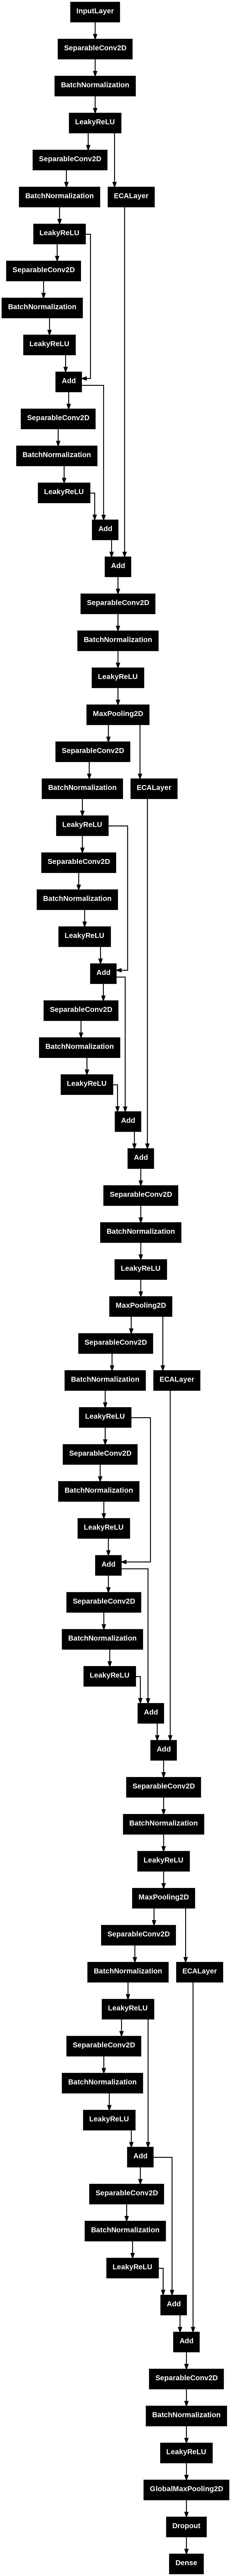

In [39]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

In [41]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(),metrics=["accuracy"])

In [42]:
def lr_schedule(epoch):
  """
  Returns a custom learning rate that decreases as epochs progress.
  """
  learning_rate = 0.01
  if epoch > 10:
    learning_rate = 0.003
  if epoch > 15:
    learning_rate = 0.002
  if epoch > 25:
    learning_rate = 0.001
  if epoch > 30:
    learning_rate = 0.0001

  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate

In [43]:
from tensorflow import keras

In [44]:
from tensorflow import keras
lr_callback = keras.callbacks.LearningRateScheduler(lr_schedule)

In [ ]:
history = model.fit(train_generator,validation_data = validation_generator,epochs=25,batch_size=16, verbose=1,callbacks=[ lr_callback])


In [ ]:

model.save('/content/drive/MyDrive/4-dense Block+leakyrELU-china-data.h5')

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LeakyReLU, ELU  # Import LeakyReLU and ELU

class ECALayer(tf.keras.layers.Layer):
    def __init__(self, k_size=3, **kwargs):
        super(ECALayer, self).__init__(**kwargs)
        self.k_size = k_size
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)
        self.conv1d = tf.keras.layers.Conv1D(filters=1, kernel_size=k_size, padding='same', use_bias=False)
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def call(self, inputs):
        y = self.avg_pool(inputs)
        y = tf.squeeze(y, axis=[1, 2])
        y = self.conv1d(tf.expand_dims(y, axis=-1))
        y = tf.squeeze(y, axis=-1)
        y = self.sigmoid(y)
        y = tf.reshape(y, (-1, 1, 1, y.shape[-1]))
        return inputs * y

# Load the model with custom objects for ECALayer, LeakyReLU, and ELU
with tf.keras.utils.custom_object_scope({'ECALayer': ECALayer, 'LeakyReLU': LeakyReLU, 'ELU': ELU}):
    model = load_model('/content/drive/MyDrive/4-dense Block+ECA_ELU.h5')

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_35       │ (None, 224, 224, 16)   │             75 │ input_layer_4[0][0]    │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, 224, 224, 16)   │             64 │ separable_conv2d_35[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ elu_39 (ELU)              │ (None, 224, 224, 16)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_36       │ (None, 224, 224, 16)   │            400 │ elu_39[0][0]           │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 224, 224, 16)   │             64 │ separable_conv2d_36[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ elu_40 (ELU)              │ (None, 224, 224, 16)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_31 (Add)              │ (None, 224, 224, 16)   │              0 │ elu_39[0][0],          │
│                           │                        │                │ elu_40[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_37       │ (None, 224, 224, 16)   │            400 │ add_31[0][0]           │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 224, 224, 16)   │             64 │ separable_conv2d_37[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ elu_41 (ELU)              │ (None, 224, 224, 16)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_32 (Add)              │ (None, 224, 224, 16)   │              0 │ add_31[0][0],          │
│                           │                        │                │ elu_41[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ separable_conv2d_38       │ (None, 224, 224, 16)   │            400 │ add_32[0][0]           │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 224, 224, 16)   │             64 │ separable_conv2d_38[0… │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 124,190 (485.12 KB)

 Trainable params: 121,758 (475.62 KB)

 Non-trainable params: 2,432 (9.50 KB)

In [ ]:
import tensorflow as tf
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder
print('TensorFlow:', tf.__version__)



forward_pass = tf.function(
    model.call,
    input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

graph_info = profile(forward_pass.get_concrete_function().graph,
                        options=ProfileOptionBuilder.float_operation())

# The //2 is necessary since `profile` counts multiply and accumulate
# as two flops, here we report the total number of multiply accumulate ops
flops = graph_info.total_float_ops // 2
print('Flops: {:,}'.format(flops))

In [ ]:
img_width=224; img_height=224

In [ ]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()


In [ ]:
fig2 = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [ ]:
img_width=224; img_height=224

In [ ]:
## Test Performance on Test Data
import pandas as pd
import numpy as np
# from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import load_img,img_to_array
def preprocess_image(path):
    img = load_img(path, target_size = (img_height, img_width))
    a = img_to_array(img)
    a = np.expand_dims(a, axis = 0)
    a = a / 255
    return a

In [ ]:
test_classes = []
main = '/content/output23/test'
test_image = []
for classes in os.listdir(main):
    path_1 = main + '/' + str(classes)
    print(classes)
    for images in os.listdir(path_1):
        test_classes.append(classes)
        test_image.append(str(images))
print(len(test_classes))
print(len(test_image))

In [ ]:
img_height=224
img_width=224



In [ ]:
main = '/content/output23/test'
test_preprocessed_images = []
for classes in os.listdir(main):
    path_1 = main + '/' + str(classes)
    for images in os.listdir(path_1):
      path_2 = path_1 + '/' + str(images)
      processed = preprocess_image(path_2)
      test_preprocessed_images.append(processed)

test_preprocessed_images = np.vstack(test_preprocessed_images)
np.save('/content/test_preproc_CNN.npy', test_preprocessed_images)

In [ ]:
array = model.predict(test_preprocessed_images, batch_size=1, verbose=1)
answer = np.argmax(array, axis=1)
print(answer)

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
y_true = test_classes
y_pred = array
print(y_true)

In [ ]:


## China Data


for x in y_true:

  if x==str('Walk_boxing'):

    index = y_true.index(x)
    y_true[index] = 5
  if x==str('Crawling'):

    index = y_true.index(x)
    y_true[index] = 1
  if x==str('Boxing'):

    index = y_true.index(x)
    y_true[index] = 0
  if x==str('Running'):

    index = y_true.index(x)
    y_true[index] = 2

  if x==str('Sitting'):

    index = y_true.index(x)
    y_true[index] = 3

  if x==str('Walk'):

    index = y_true.index(x)
    y_true[index] = 4
  if x==str('Walk_hold'):

    index = y_true.index(x)
    y_true[index] = 6
print(y_true)

### DIAT_data

for x in y_true:

  if x==str('Walking'):

    index = y_true.index(x)
    y_true[index] = 5
  if x==str('Crawling'):

    index = y_true.index(x)
    y_true[index] = 1
  if x==str('Boxing'):

    index = y_true.index(x)
    y_true[index] = 0
  if x==str('Jogging'):

    index = y_true.index(x)
    y_true[index] = 2
  if x==str('Jumping'):

    index = y_true.index(x)
    y_true[index] = 3
  if x==str('Throwing'):

    index = y_true.index(x)
    y_true[index] = 4
print(y_true)


In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true, answer)
conf_mat

In [ ]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm.round(2)
        # print("Normalized confusion matrix")
    else:
        cm = cm
        # print('Confusion matrix, without normalization')

    # print(cm)

    # Calculate accuracy and misclassification rate
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclassification_rate = 1 - accuracy

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel(f'Predicted label\nAccuracy={accuracy:.2f}; Misclassification Rate={misclassification_rate:.2f}')
    plt.show()

In [ ]:
classes = os.listdir('/content/output23/test')
print(classes)

In [ ]:
np.set_printoptions(precision=2)

fig1 = plt.figure(figsize=(8,8))
plot_confusion_matrix(conf_mat, classes=classes, title='Confusion matrix, without normalization')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(y_true, answer,digits = 4))

In [ ]:
y_prob = array

In [ ]:
# After conversion
print(set(y_true))  # Check unique elements to confirm they are all numeric


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the labels for multi-class setup
y_true_binarized = label_binarize(y_true, classes=np.unique(y_true))

# Calculating ROC AUC Score
auc_roc_scores = []
for i in range(y_true_binarized.shape[1]):
    auc_roc = roc_auc_score(y_true_binarized[:, i], y_prob[:, i])
    auc_roc_scores.append(auc_roc)

average_auc_roc = np.mean(auc_roc_scores)
print("Average AUC-ROC:", average_auc_roc)


In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np

# Assuming y_true are the numeric labels
classes = np.unique(y_true)
y_true_binarized = label_binarize(y_true, classes=classes)


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calculate ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


In [ ]:
# Plotting
plt.figure(figsize=(10, 8))
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(classes))))
for i, color in zip(range(len(classes)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()


 Load and Preprocess Image

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step


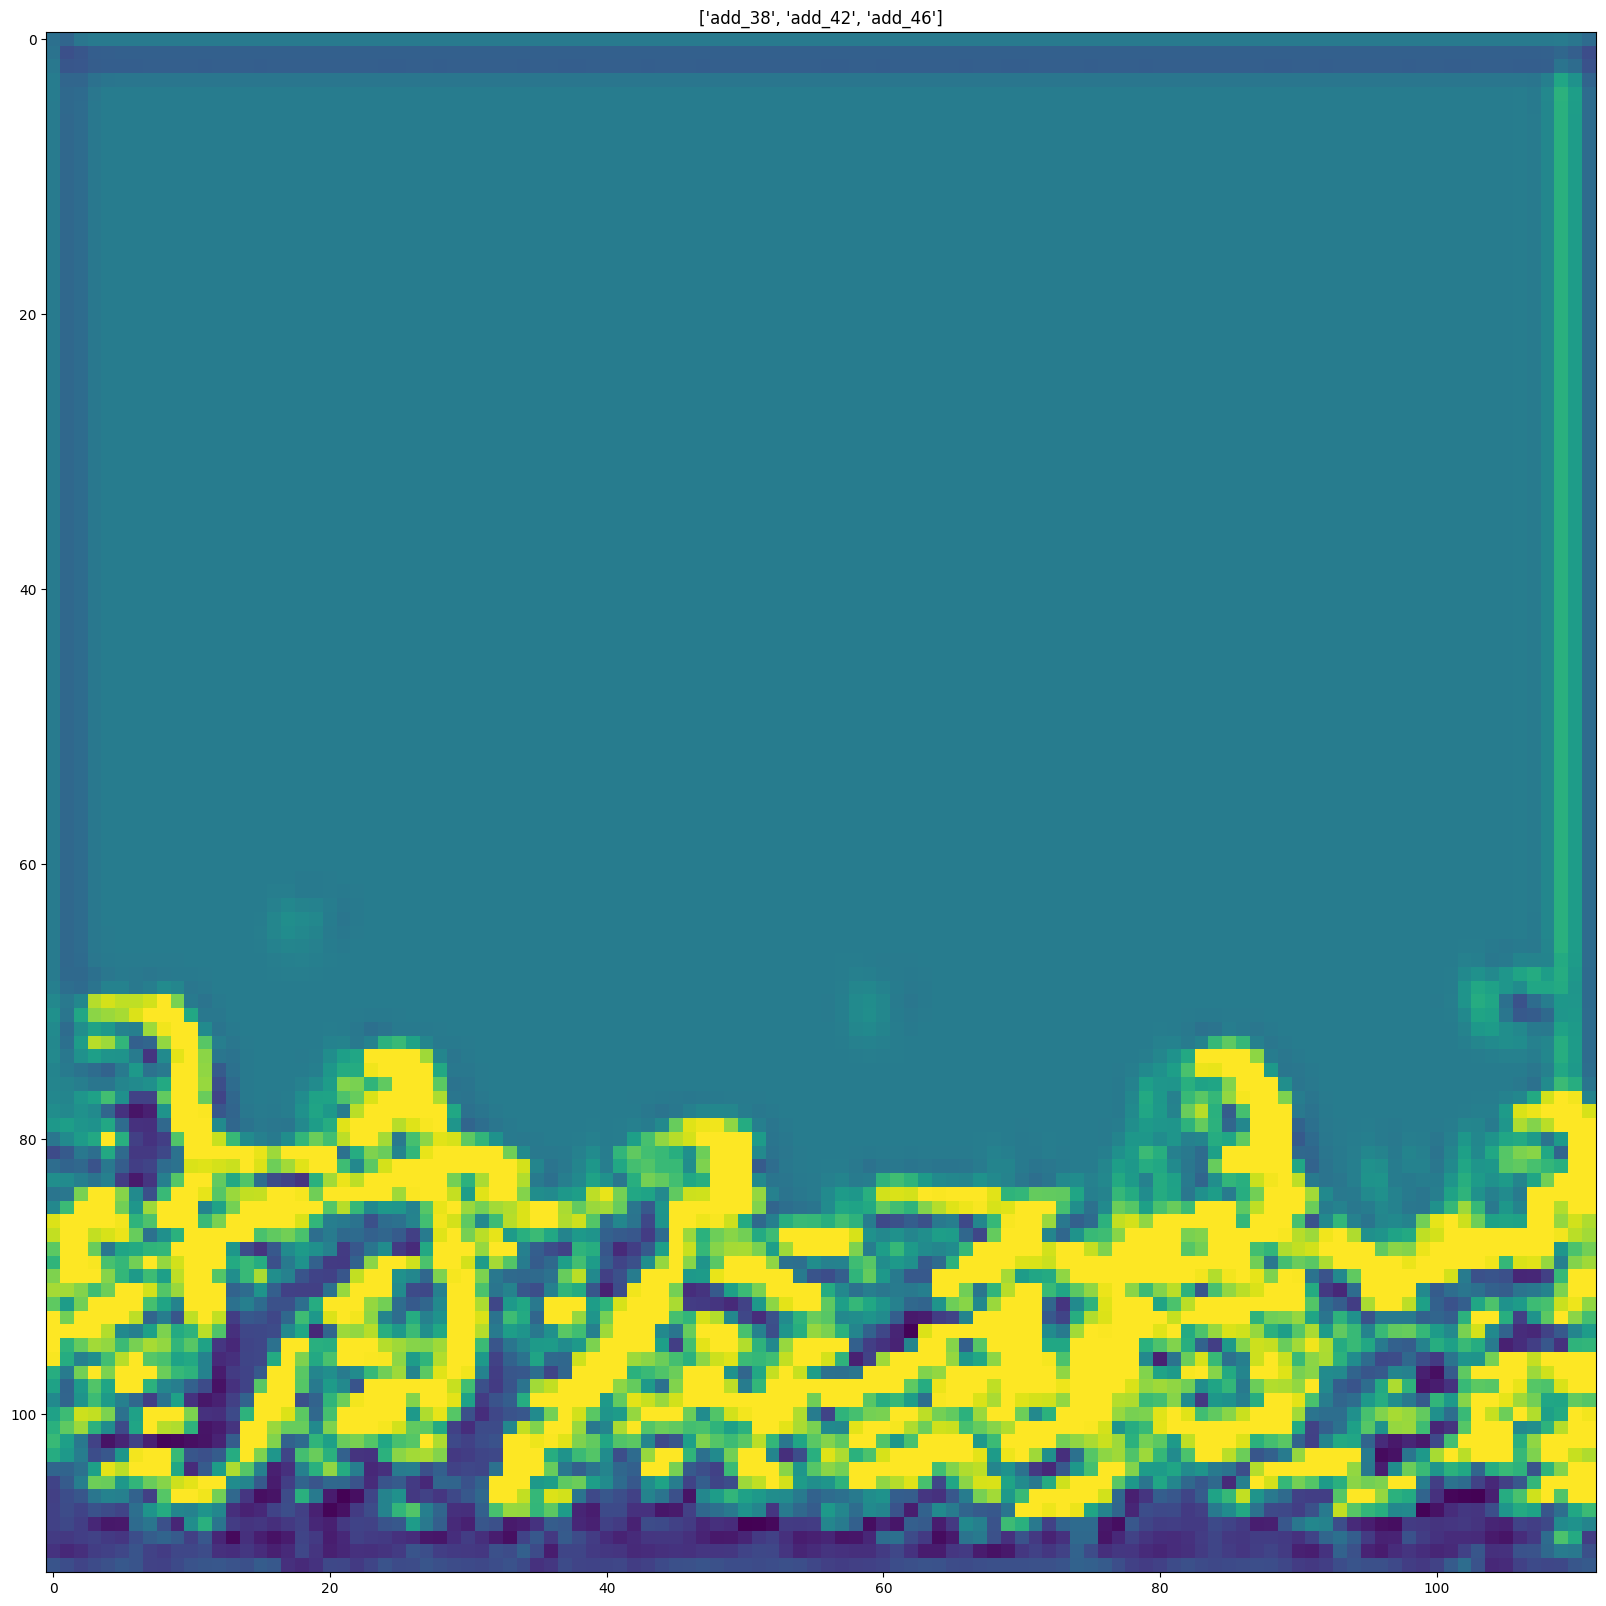

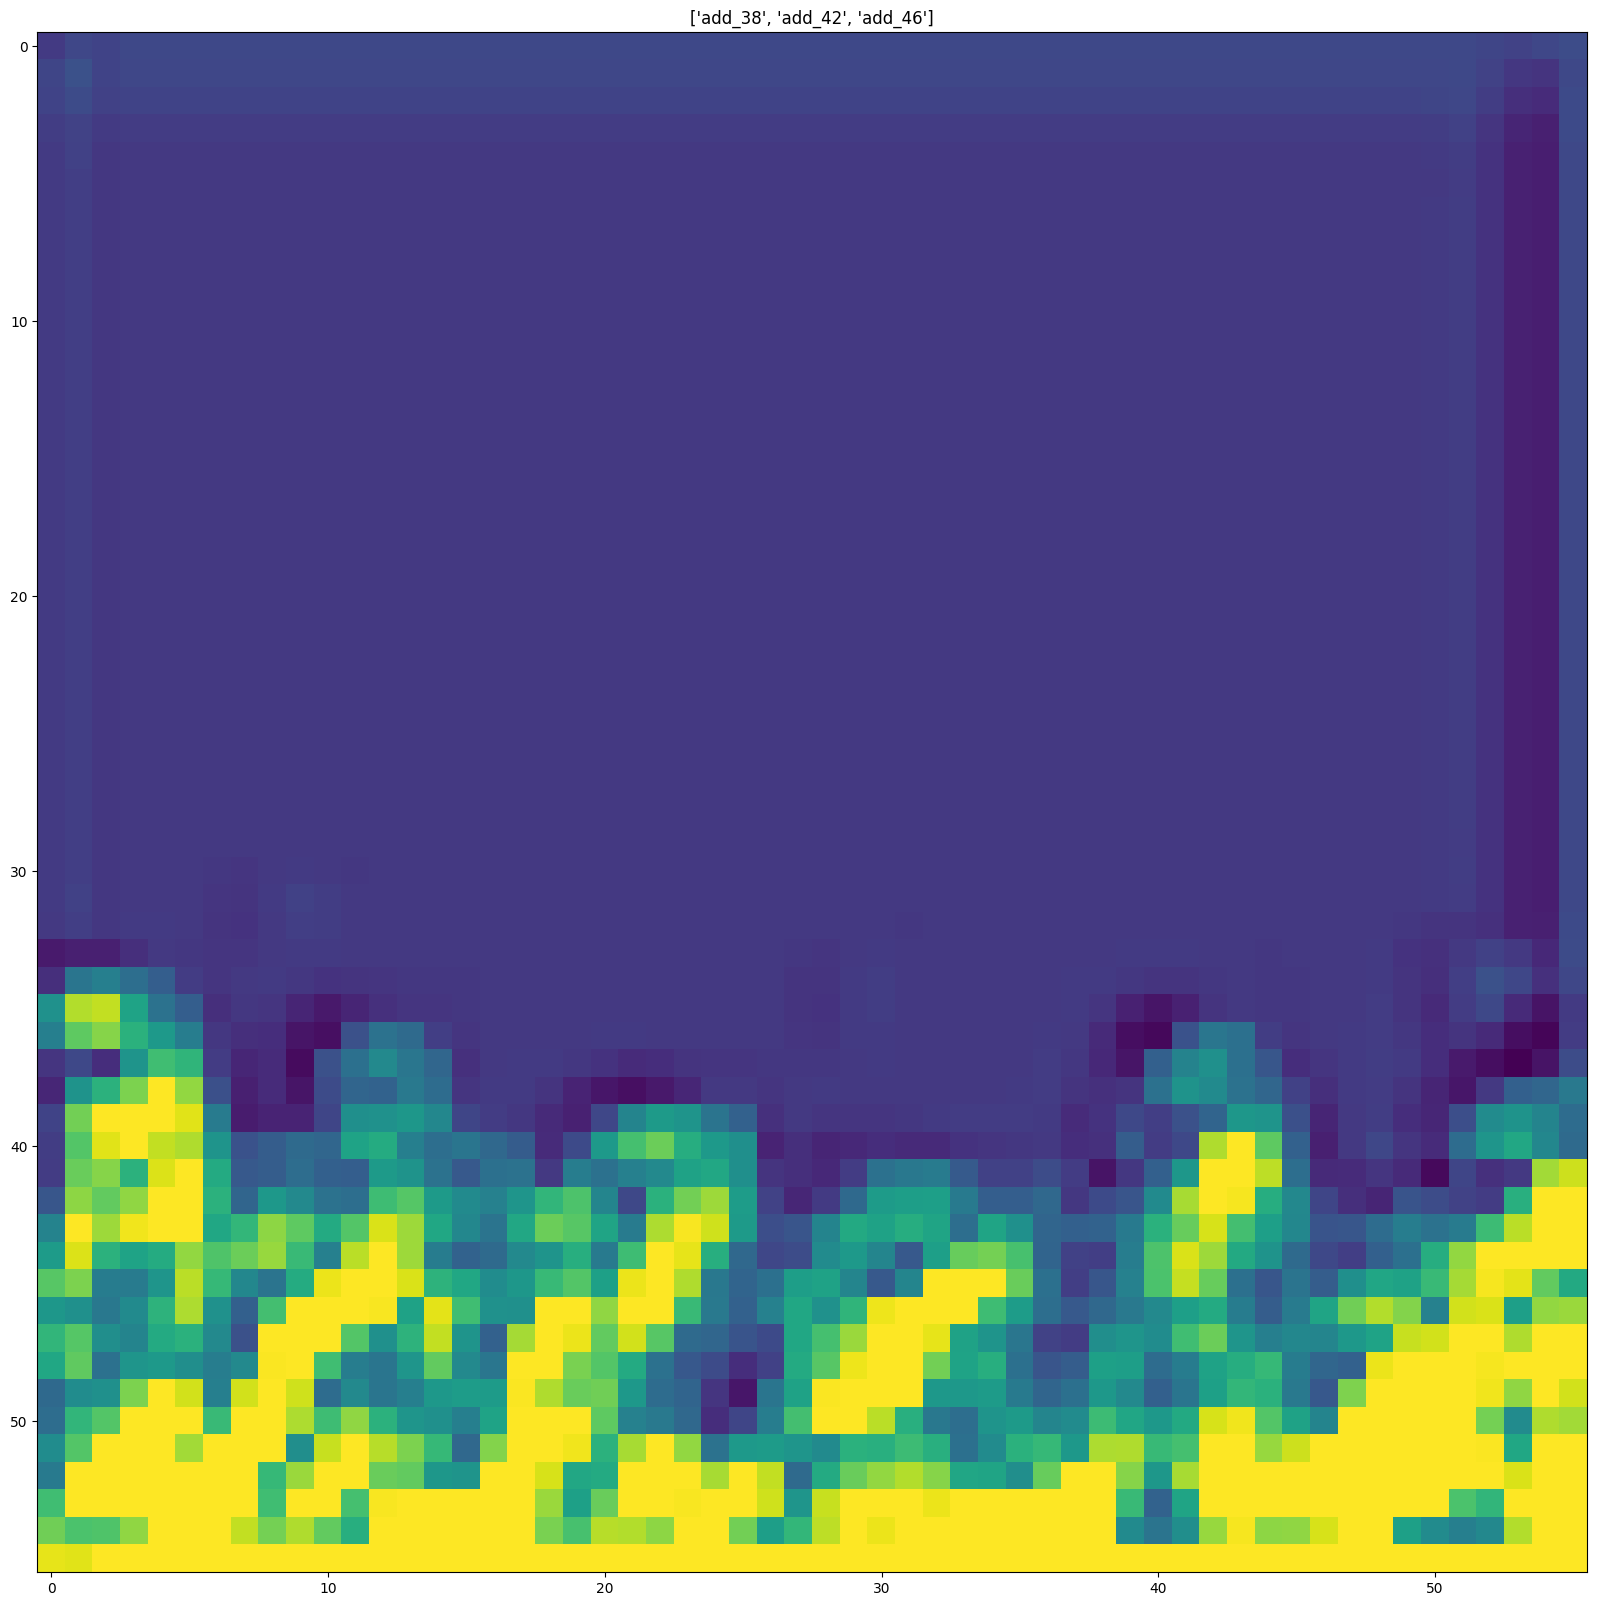

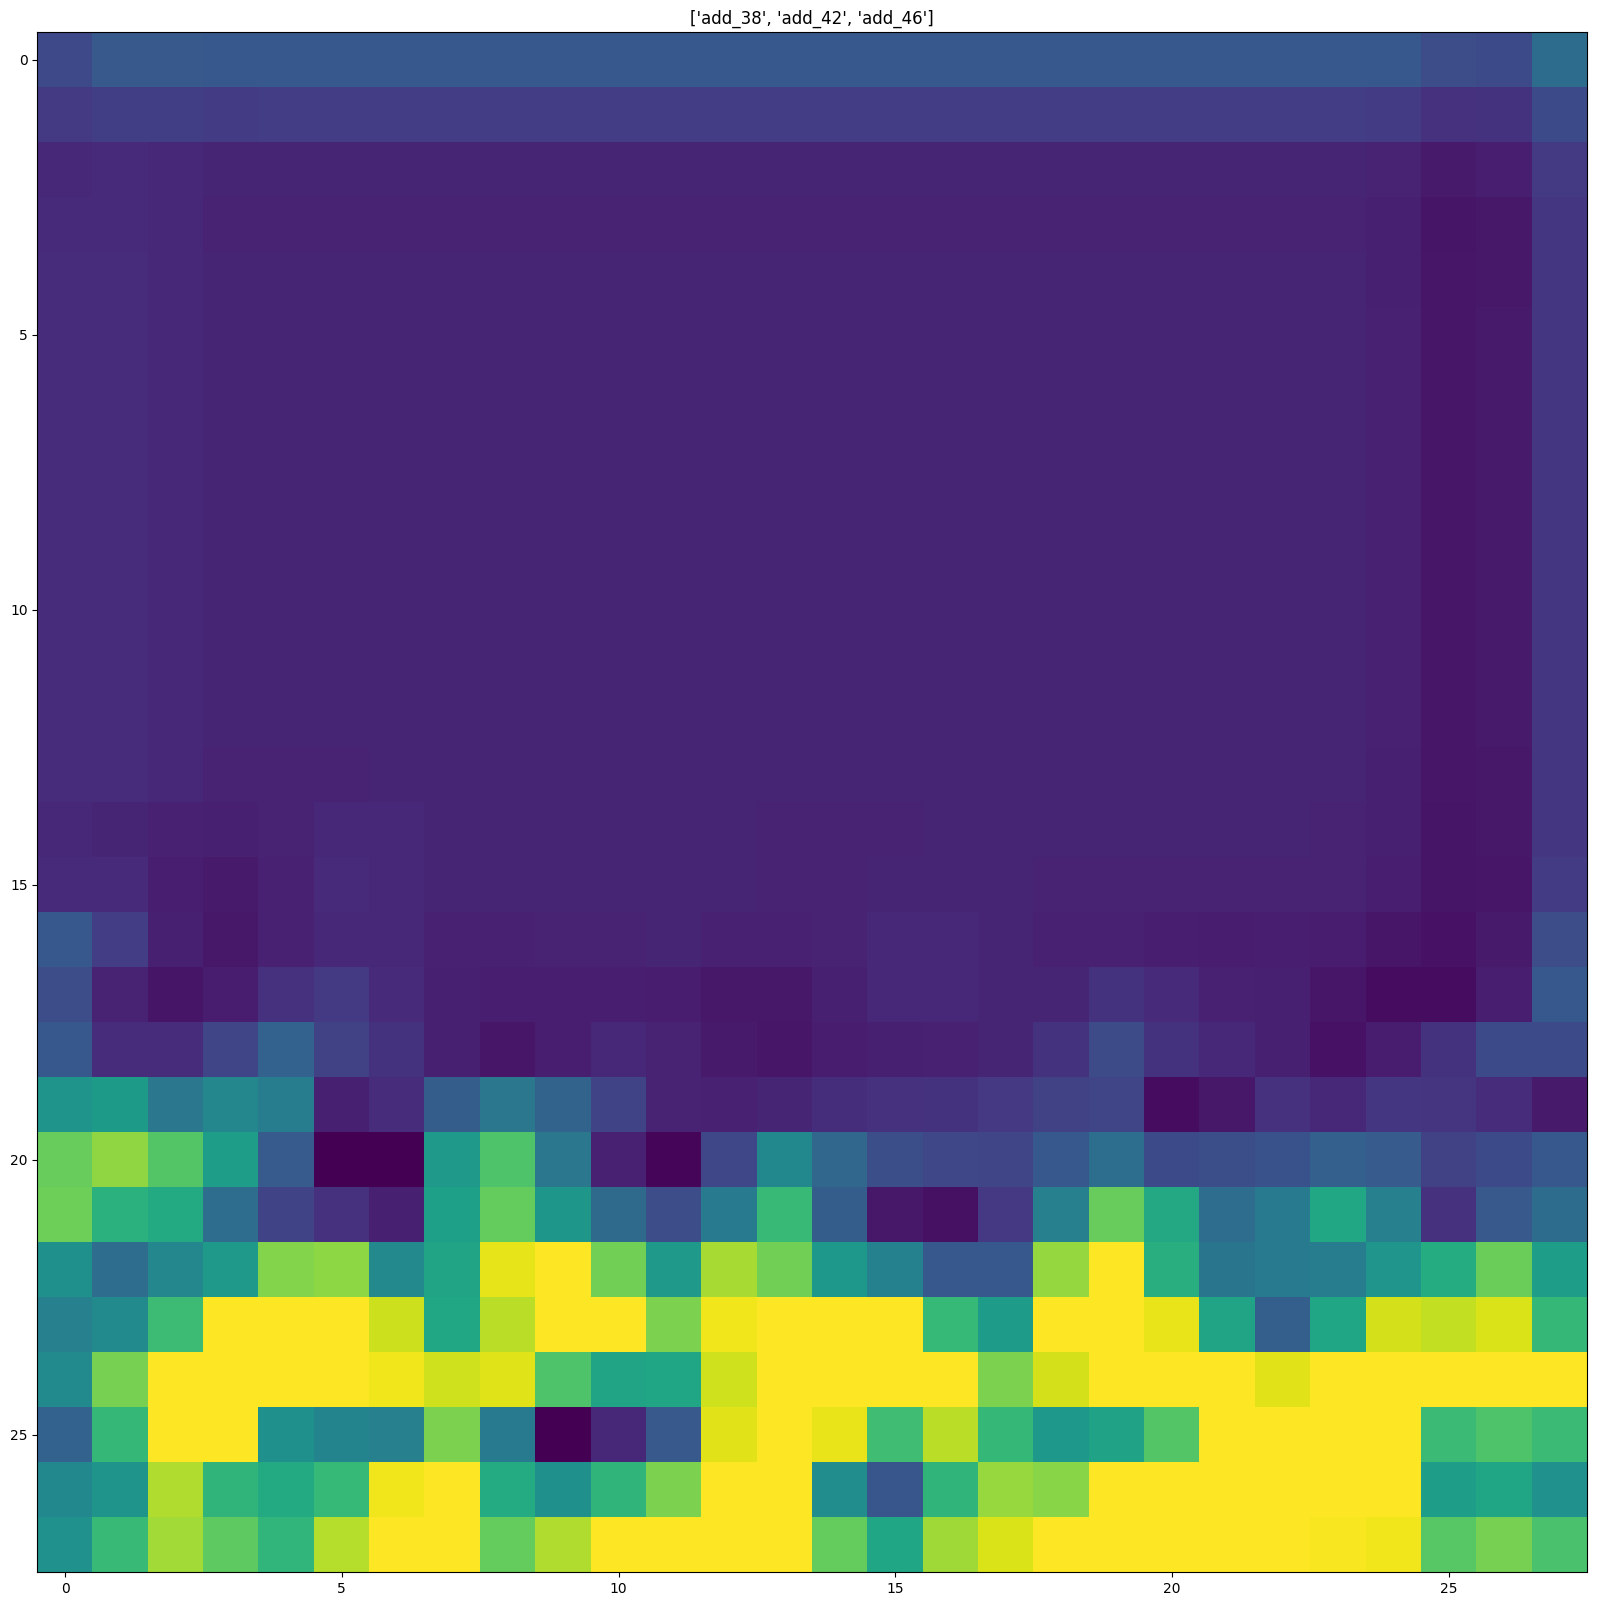

In [ ]:
### Feature maps of proposed model at different stages -code 01

# Load and preprocess the test image
def load_test_image(image_path, target_size):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize to [0, 1] range
    return img

# Function to plot feature maps
def plot_feature_maps(model, layer_names, img):
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[model.get_layer(name).output for name in layer_names])
    intermediate_output = intermediate_layer_model.predict(img)

    for layer_output in intermediate_output:
        n_features = 1  # Number of features in the feature map
        size = layer_output.shape[1]  # Width and height of the feature map
        display_grid = np.zeros((size, size * n_features))

        for i in range(n_features):
            x = layer_output[0, :, :, i]
            x -= x.mean()
            x /= (x.std() + 1e-5)
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size: (i + 1) * size] = x

        scale = 20. / n_features
        plt.figure(figsize=(scale * n_features, scale))
        plt.title(layer_names)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
        plt.show()

# Load the test image
test_image_path = '/content/drive/MyDrive/figure1.jpg'  # Update with the path to your test image
test_image = load_test_image(test_image_path, target_size=(224, 224))

# Plot feature maps for x111, x112, and x113
layer_names = ['add_38','add_42','add_46']  # Update with correct activation layer names
plot_feature_maps(model, layer_names, test_image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


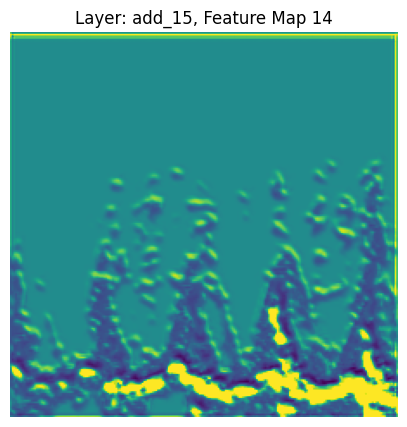

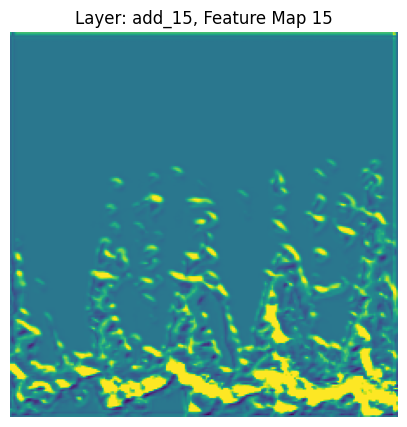

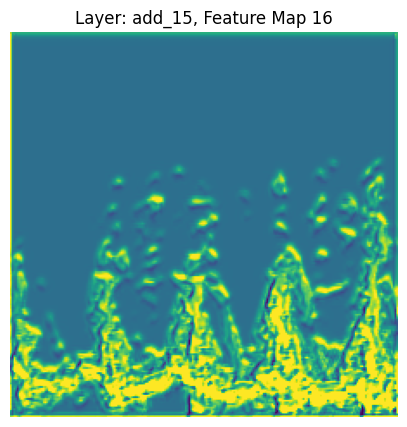

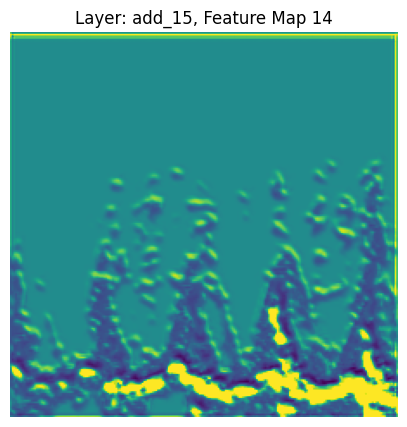

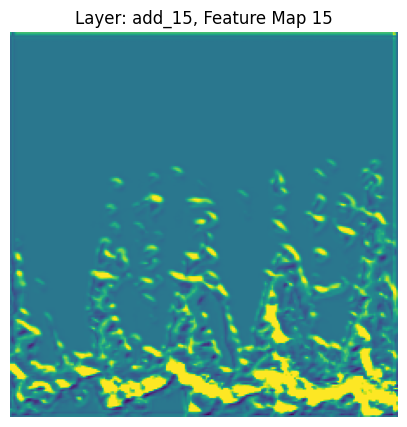

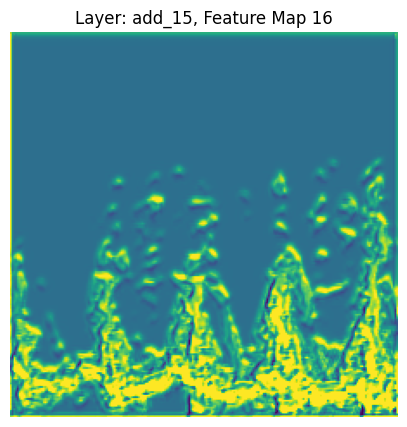

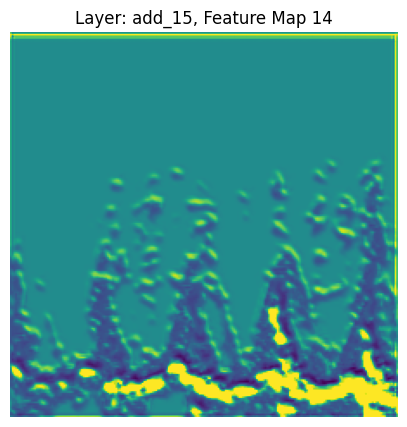

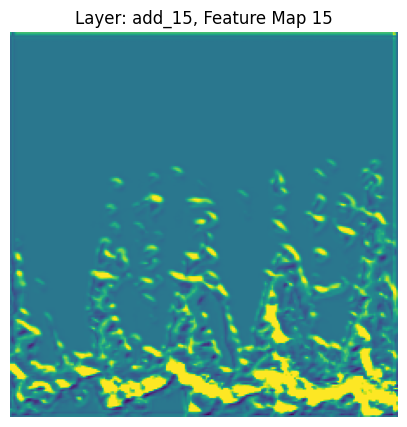

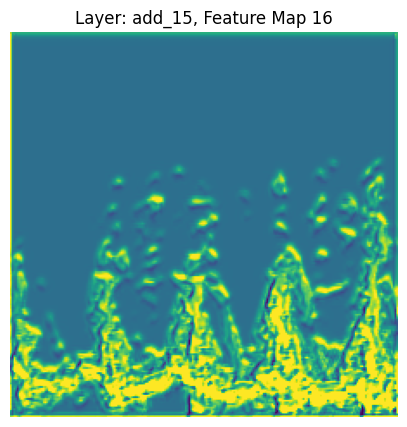

In [ ]:
### Feature maps of proposed model at different stages- code 02

# Load and preprocess the test image
def load_test_image(image_path, target_size):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize to [0, 1] range
    return img
# Function to plot only the last 3 feature maps for each layer
# Function to plot only the last 3 feature maps for each layer as single images
def plot_feature_maps(model, layer_names, img):
    # Verify if the specified layer names exist in the model
    available_layers = [layer.name for layer in model.layers]
    for name in layer_names:
        if name not in available_layers:
            print(f"Layer '{name}' not found in model. Please verify layer names.")
            return  # Exit function if any layer is missing

    # Get outputs of the specified intermediate layers
    intermediate_layer_model = Model(inputs=model.input,
                                     outputs=[model.get_layer(name).output for name in layer_names])
    intermediate_output = intermediate_layer_model.predict(img)

    # Plot each of the last 3 feature maps for each specified layer
    for idx, layer_output in enumerate(intermediate_output):
        n_features = layer_output.shape[-1]
        last_three_features = range(n_features - 3, n_features)  # Indices of the last 3 feature maps

        for i, feature_idx in enumerate(last_three_features):
            x = layer_output[0, :, :, feature_idx]
            x -= x.mean()
            x /= (x.std() + 1e-5)
            x *= 64
            x += 128
            x = np.clip(x, 0, 255).astype('uint8')

            plt.figure(figsize=(5, 5))
            plt.title(f"Layer: {layer_names[idx]}, Feature Map {feature_idx + 1}")
            plt.grid(False)
            plt.imshow(x, aspect='auto', cmap='viridis')
            plt.axis('off')  # Turn off axis
            plt.show()



# Load the test image
test_image_path = '/content/drive/MyDrive/figure1.jpg'  # Update with the path to your test image
test_image = load_test_image(test_image_path, target_size=(224, 224))

# Plot feature maps for x111, x112, and x113
layer_names = ['add_15', 'add_15', 'add_15']  # Update with correct activation layer names
plot_feature_maps(model, layer_names, test_image)

In [ ]:
# import numpy as np
# import tensorflow as tf
# import cv2
# from tensorflow.keras.applications import VGG19
# from tensorflow.keras.preprocessing import image as keras_image
# from google.colab.patches import cv2_imshow  # Import for image display in Colab

# class GradCAM:
#     def __init__(self, model, classIdx, layerName="block5_conv3"):  # Set layerName here
#         self.model = model
#         self.classIdx = classIdx
#         self.layerName = layerName

#     def compute_heatmap(self, image, eps=1e-8):
#         # Create a model that outputs the last convolutional layer and the model's predictions
#         gradModel = tf.keras.models.Model(
#             inputs=[self.model.inputs],
#             outputs=[self.model.get_layer(self.layerName).output, self.model.output])

#         # Record the gradients
#         with tf.GradientTape() as tape:
#             inputs = tf.cast(image, tf.float32)
#             (convOutputs, predictions) = gradModel(inputs)
#             loss = predictions[:, self.classIdx]

#         # Calculate gradients of the loss with respect to the convolutional layer's outputs
#         grads = tape.gradient(loss, convOutputs)

#         # Create the guided gradients
#         castConvOutputs = tf.cast(convOutputs > 0, "float32")
#         castGrads = tf.cast(grads > 0, "float32")
#         guidedGrads = castConvOutputs * castGrads * grads

#         # Compute the Grad-CAM heatmap
#         convOutputs = convOutputs[0]
#         guidedGrads = guidedGrads[0]
#         weights = tf.reduce_mean(guidedGrads, axis=(0, 1))

#         # Weighted combination of the feature maps
#         cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

#         # Resize the heatmap to match the input image size
#         (h, w) = (image.shape[1], image.shape[2])  # Get dimensions from the image
#         heatmap = cv2.resize(cam.numpy(), (w, h))

#         # Normalize the heatmap
#         numer = heatmap - np.min(heatmap)
#         denom = (heatmap.max() - heatmap.min()) + eps
#         heatmap = numer / denom
#         heatmap = (heatmap * 255).astype("uint8")

#         return heatmap

#     def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap='cv2.COLORMAP_OCEAN'
# ):
#         # Apply the colormap to the heatmap
#         heatmap = cv2.applyColorMap(heatmap, colormap)
#         output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
#         return (heatmap, output)

# # Example usage
# def preprocess_image(img_path):
#     img = keras_image.load_img(img_path, target_size=(224, 224))
#     img = keras_image.img_to_array(img)
#     img = np.expand_dims(img, axis=0)
#     return img

# # Load the pre-trained VGG19 model
# model = VGG19(weights='imagenet')

# # Specify the class index you want to visualize
# class_index = 508  # For example, 'African elephant'

# # Preprocess the image
# img_path = '/content/drive/MyDrive/figure1.jpg'  # Update with your image path
# image = preprocess_image(img_path)

# # Initialize Grad-CAM with specified layer name
# cam = GradCAM(model, class_index, layerName="block5_conv3")  # Specify layerName here

# # Compute the heatmap
# heatmap = cam.compute_heatmap(image)

# # Load the original image and resize it (keeping its color intact)
# original_image = cv2.imread(img_path)
# original_image_resized = cv2.resize(original_image, (224, 224))  # Resize to match the heatmap

# # Overlay heatmap on the original image (original colors are preserved)
# heatmap_overlay, output = cam.overlay_heatmap(heatmap, original_image_resized)

# # Show the results using cv2_imshow instead of cv2.imshow
# cv2_imshow(heatmap_overlay)  # Display the heatmap overlay
# cv2_imshow(original_image_resized)  # Display the original image
# cv2_imshow(output)  # Display the output with heatmap overlay


error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'applyColorMap'
> Overload resolution failed:
>  - Argument 'colormap' is required to be an integer
>  - Argument 'colormap' is required to be an integer
>  - userColor is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'userColor'


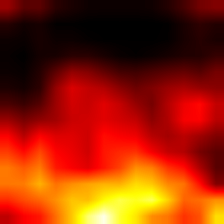

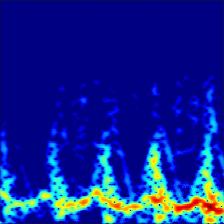

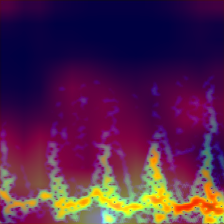

In [ ]:
## GradCAM

import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image as keras_image
from google.colab.patches import cv2_imshow  # Import for image display in Colab

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # Find the last convolutional layer in the model
        for layer in reversed(self.model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                return layer.name
        raise ValueError("Could not find a convolutional layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # Create a model that outputs the last convolutional layer and the model's predictions
        gradModel = tf.keras.models.Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # Record the gradients
        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # Calculate gradients of the loss with respect to the convolutional layer's outputs
        grads = tape.gradient(loss, convOutputs)

        # Create the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # Compute the Grad-CAM heatmap
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))

        # Weighted combination of the feature maps
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # Resize the heatmap to match the input image size
        (h, w) = (image.shape[1], image.shape[2])  # Get dimensions from the image
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # Normalize the heatmap
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_HOT):
        # Apply the colormap to the heatmap
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

# Example usage
def preprocess_image(img_path):
    img = keras_image.load_img(img_path, target_size=(224, 224))
    img = keras_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

# Load the pre-trained VGG16 model
model = VGG19(weights='imagenet')

# Specify the class index you want to visualize
class_index = 508

# Preprocess the image
img_path = '/content/drive/MyDrive/figure1.jpg'  # Update with your image path
image = preprocess_image(img_path)

# Initialize Grad-CAM
cam = GradCAM(model, class_index)

# Compute the heatmap
heatmap = cam.compute_heatmap(image)

# Load the original image and resize it (keeping its color intact)
original_image = cv2.imread(img_path)
original_image_resized = cv2.resize(original_image, (224, 224))  # Resize to match the heatmap

# Overlay heatmap on the original image (original colors are preserved)
heatmap_overlay, output = cam.overlay_heatmap(heatmap, original_image_resized)

# Show the results using cv2_imshow instead of cv2.imshow
cv2_imshow(heatmap_overlay)  # Display the heatmap overlay
cv2_imshow(original_image_resized)  # Display the original image
cv2_imshow(output)  # Display the output with heatmap overlay


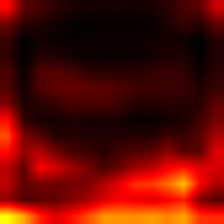

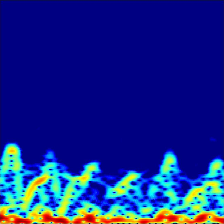

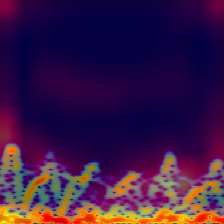

In [51]:

### Proposed Model

import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.preprocessing import image as keras_image
from google.colab.patches import cv2_imshow  # Import for image display in Colab

# Define the ECALayer class
class ECALayer(tf.keras.layers.Layer):
    def __init__(self, k_size=3, **kwargs):
        super(ECALayer, self).__init__(**kwargs)  # Pass any extra arguments to the parent class
        self.k_size = k_size
        self.avg_pool = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)
        self.conv1d = tf.keras.layers.Conv1D(filters=1, kernel_size=k_size, padding='same', use_bias=False)
        self.sigmoid = tf.keras.layers.Activation('sigmoid')

    def call(self, inputs):
        y = self.avg_pool(inputs)  # Shape: (batch_size, 1, 1, channels)
        y = tf.squeeze(y, axis=[1, 2])  # Shape: (batch_size, channels)
        y = self.conv1d(tf.expand_dims(y, axis=-1))  # Shape: (batch_size, channels, 1)
        y = tf.squeeze(y, axis=-1)  # Shape: (batch_size, channels)
        y = self.sigmoid(y)  # Shape: (batch_size, channels)
        y = tf.reshape(y, (-1, 1, 1, y.shape[-1]))  # Shape: (batch_size, 1, 1, channels)
        return inputs * y

# GradCAM class
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        for layer in reversed(self.model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                return layer.name
        raise ValueError("Could not find a convolutional layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        gradModel = tf.keras.models.Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        with tf.GradientTape() as tape:
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        grads = tape.gradient(loss, convOutputs)
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        (h, w) = (image.shape[1], image.shape[2])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_HOT):
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        return (heatmap, output)

# Function to preprocess the image
def preprocess_image(img_path):
    img = keras_image.load_img(img_path, target_size=(224, 224))
    img = keras_image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

# Load the proposed model with the custom ECALayer
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_custom_objects

model_path = '/content/drive/MyDrive/4-dense Block+leakyrELU-diat-data.h5'

# Include ECALayer in custom objects for model loading
get_custom_objects().update({'ECALayer': ECALayer})
model = load_model(model_path)

# Specify the class index
class_index = 0

# Preprocess the image
img_path = '/content/drive/MyDrive/figure1.jpg'
image = preprocess_image(img_path)

# Initialize Grad-CAM
cam = GradCAM(model, class_index)

# Compute the heatmap
heatmap = cam.compute_heatmap(image)

# Load the original image and resize it
original_image = cv2.imread(img_path)
original_image_resized = cv2.resize(original_image, (224, 224))

# Overlay heatmap on the original image
heatmap_overlay, output = cam.overlay_heatmap(heatmap, original_image_resized)

# Show results
cv2_imshow(heatmap_overlay)
cv2_imshow(original_image_resized)
cv2_imshow(output)


In [ ]:
# ###Layer 0: input_1
# Layer 1: block1_conv1
# Layer 2: block1_conv2
# Layer 3: block1_pool
# Layer 4: block2_conv1
# Layer 5: block2_conv2
# Layer 6: block2_pool
# Layer 7: block3_conv1
# Layer 8: block3_conv2
# Layer 9: block3_conv3
# Layer 10: block3_pool
# Layer 11: block4_conv1
# Layer 12: block4_conv2
# Layer 13: block4_conv3
# Layer 14: block4_pool
# Layer 15: block5_conv1
# Layer 16: block5_conv2
# Layer 17: block5_conv3
# Layer 18: block5_pool
# Layer 19: flatten
# Layer 20: fc1
# Layer 21: fc2
# Layer 22: predictions


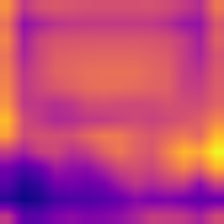

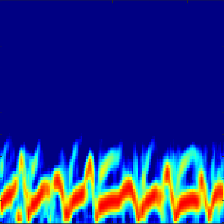

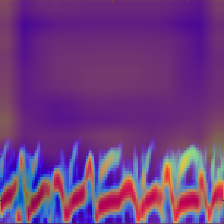

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image as keras_image
from google.colab.patches import cv2_imshow  # Import for image display in Colab
from tensorflow.keras.models import Model

class GradCAMPlusPlus:
    def __init__(self, model, classIdx, layerName=None):
        self.model = model
        self.classIdx = classIdx
        if layerName is None:
            self.layerName = self.find_target_layer()
        else:
            self.layerName = layerName

    def find_target_layer(self):
        # Find the last convolutional layer in the model
        for layer in reversed(self.model.layers):
            if isinstance(layer, tf.keras.layers.Conv2D):
                return layer.name
        raise ValueError("Could not find a convolutional layer. Cannot apply Grad-CAM++.")

    def compute_heatmap(self, image):
        img_tensor = np.expand_dims(image, axis=0)

        conv_layer = self.model.get_layer(self.layerName)
        heatmap_model = Model(inputs=self.model.inputs, outputs=[conv_layer.output, self.model.output])

        with tf.GradientTape() as gtape1:
            with tf.GradientTape() as gtape2:
                with tf.GradientTape() as gtape3:
                    conv_output, predictions = heatmap_model(img_tensor)
                    output = predictions[:, self.classIdx]

                    # Calculate the gradients
                    conv_first_grad = gtape3.gradient(output, conv_output)
                conv_second_grad = gtape2.gradient(conv_first_grad, conv_output)
            conv_third_grad = gtape1.gradient(conv_second_grad, conv_output)

        global_sum = np.sum(conv_output, axis=(0, 1, 2))

        alpha_num = conv_second_grad[0]
        alpha_denom = conv_second_grad[0] * 2.0 + conv_third_grad[0] * global_sum
        alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

        alphas = alpha_num / alpha_denom
        alpha_normalization_constant = np.sum(alphas, axis=(0, 1))
        alphas /= alpha_normalization_constant

        weights = np.maximum(conv_first_grad[0], 0.0)

        deep_linearization_weights = np.sum(weights * alphas, axis=(0, 1))
        grad_cam_map = np.sum(deep_linearization_weights * conv_output[0], axis=2)

        heatmap = np.maximum(grad_cam_map, 0)
        max_heat = np.max(heatmap)
        if max_heat == 0:
            max_heat = 1e-10
        heatmap /= max_heat

        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_OCEAN):
        # Resize heatmap to match the original image dimensions
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

        # Apply the colormap to the heatmap
        heatmap_colored = cv2.applyColorMap((heatmap * 255).astype(np.uint8), colormap)

        # Combine the original image and heatmap
        output = cv2.addWeighted(image, alpha, heatmap_colored, 1 - alpha, 0)

        return heatmap_colored, output


# Function to preprocess the image
def preprocess_image(img_path):
    img = keras_image.load_img(img_path, target_size=(224, 224))
    img = keras_image.img_to_array(img)
    img = img / 255.0  # Normalize the image to [0, 1]
    return img

# Example usage
if __name__ == "__main__":
    # Load the pre-trained VGG19 model
    model = VGG16(weights='imagenet')

    # Specify the class index you want to visualize
    class_index = 508  # For example, 'African elephant'

    # Preprocess the image
    img_path = '/content/drive/MyDrive/China_revised_HAR_Data/Boxing/a2.png'  # Update with your image path
    image = preprocess_image(img_path)

    # Initialize Grad-CAM++
    cam = GradCAMPlusPlus(model, class_index)

    # Compute the heatmap
    heatmap = cam.compute_heatmap(image)

    # Load the original image and resize it
    original_image = cv2.imread(img_path)
    original_image_resized = cv2.resize(original_image, (224, 224))  # Resize to match the heatmap

    # Overlay heatmap on the original image
    heatmap_overlay, output = cam.overlay_heatmap(heatmap, original_image_resized)

    # Show the results using cv2_imshow
    cv2_imshow(heatmap_overlay)  # Display the heatmap overlay
    cv2_imshow(original_image_resized)  # Display the original image
    cv2_imshow(output)  # Display the output with heatmap overlay


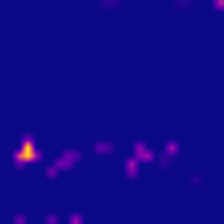

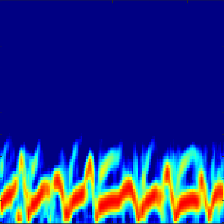

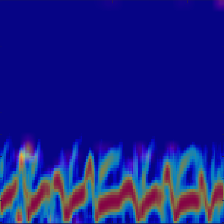

In [ ]:
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing import image as keras_image
from google.colab.patches import cv2_imshow  # Import for image display in Colab
from tensorflow.keras.models import Model

class GradCAMPlusPlus:
    def __init__(self, model, classIdx, layerName="block5_conv3", labelNames=None):
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        self.labelNames = labelNames

    def compute_heatmap(self, image, category_id=None):
        img_tensor = np.expand_dims(image, axis=0)

        conv_layer = self.model.get_layer(self.layerName)
        heatmap_model = Model(inputs=self.model.inputs, outputs=[conv_layer.output, self.model.output])

        with tf.GradientTape() as gtape:
            conv_output, predictions = heatmap_model(img_tensor)
            if category_id is None:
                category_id = np.argmax(predictions[0])  # Default to the class with the highest score
            if self.labelNames is not None:
                print(self.labelNames[category_id])
            output = predictions[:, category_id]
            grads = gtape.gradient(output, conv_output)
            pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Compute the heatmap
        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
        heatmap = np.maximum(heatmap, 0)
        max_heat = np.max(heatmap)
        if max_heat == 0:
            max_heat = 1e-10
        heatmap /= max_heat

        return np.squeeze(heatmap)

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_OCEAN):
        # Resize heatmap to match the original image dimensions
        heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))

        # Apply the colormap to the heatmap
        heatmap_colored = cv2.applyColorMap((heatmap * 255).astype(np.uint8), colormap)

        # Combine the original image and heatmap
        output = cv2.addWeighted(image, alpha, heatmap_colored, 1 - alpha, 0)

        return heatmap_colored, output


# Function to preprocess the image
def preprocess_image(img_path):
    img = keras_image.load_img(img_path, target_size=(224, 224))
    img = keras_image.img_to_array(img)
    img = img / 255.0  # Normalize the image to [0, 1]
    return img

# Example usage
if __name__ == "__main__":
    # Load the pre-trained VGG16 model
    model = VGG19(weights='imagenet')

    # Specify the class index you want to visualize
    class_index = 508  # For example, 'African elephant'

    # Preprocess the image
    img_path = '/content/drive/MyDrive/China_revised_HAR_Data/Boxing/a2.png'  # Update with your image path
    image = preprocess_image(img_path)

    # Initialize Grad-CAM++
    cam = GradCAMPlusPlus(model, class_index)

    # Compute the heatmap
    heatmap = cam.compute_heatmap(image)

    # Load the original image and resize it
    original_image = cv2.imread(img_path)
    original_image_resized = cv2.resize(original_image, (224, 224))  # Resize to match the heatmap

    # Overlay heatmap on the original image
    heatmap_overlay, output = cam.overlay_heatmap(heatmap, original_image_resized)

    # Show the results using cv2_imshow
    cv2_imshow(heatmap_overlay)  # Display the heatmap overlay
    cv2_imshow(original_image_resized)  # Display the original image
    cv2_imshow(output)  # Display the output with heatmap overlay


CAM values: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0.]
 [0. 0. 0

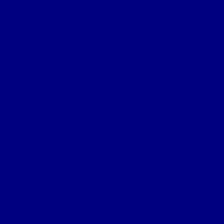

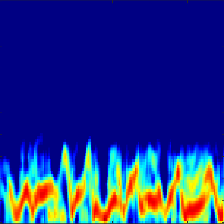

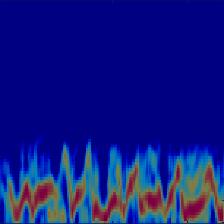